In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.linalg import eig, eigh
from scipy.linalg import null_space
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import curve_fit
from scipy.integrate import simps 

In [3]:
def sample_special_positions(a, size, prob_C, prob_e):
    # Total number of unit cells
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

    # How many atoms to sample
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)
    total_specials = num_C + num_e

    # Sample linear indices (0 to Natoms-1)
    indices = np.random.choice(Natoms, total_specials, replace=False)
    carbon_indices = np.random.choice(indices, num_C, replace=False)
    electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

    # Convert linear index to (unit cell index, basis atom index)
    unit_index = indices // 8
    basis_index = indices % 8

    # Map unit index back to (l, m, n) grid coordinates
    n_grid = len(grid_range)
    L = unit_index // (n_grid ** 2)
    M = (unit_index // n_grid) % n_grid
    N = unit_index % n_grid
    L = L + grid_range[0]
    M = M + grid_range[0]
    N = N + grid_range[0]

    # FCC + offset basis
    basis = (a/2)*np.array([
        [0, 0, 0],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [0.5, 0.5, 0.5],
        [1.5, 1.5, 0.5],
        [1.5, 0.5, 1.5],
        [0.5, 1.5, 1.5],
    ])

    # Construct positions
    unit_coords = np.stack([L, M, N], axis=1) * a
    special_positions = unit_coords + basis[basis_index]

    # Split into carbon and electron positions
    carbon_pts = special_positions[np.isin(indices, carbon_indices)]
    e_pts = special_positions[np.isin(indices, electron_indices)]

    return carbon_pts, e_pts

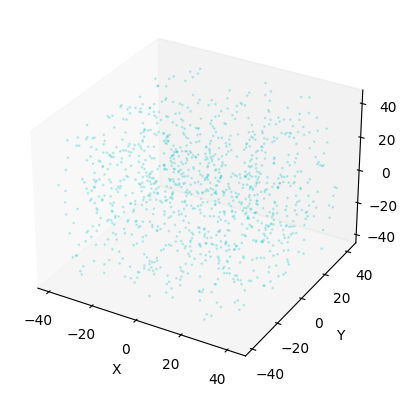

number of carbons = 1070
box_size = 82.11


In [4]:
size = 11
carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.2, s=1)
ax.scatter(e_pts[:,0], e_pts[:,1], e_pts[:,2], color='r', marker='o', alpha = 1, s=20)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

print(f'number of carbons = {carbon_pts.shape[0]}')
print(f'box_size = {3.57 * (2*size + 1)}')

In [5]:
def get_labels(size, prob_C, prob_e):
    # Total number of unit cells
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

    # How many atoms to sample
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)

    return num_C


concentration = 1.1e-2
for size in range(1,25):
    num_C = get_labels(size, concentration, 30e-6)
    print(size, 'corresponds to', num_C, 'spins')

1 corresponds to 2 spins
2 corresponds to 11 spins
3 corresponds to 30 spins
4 corresponds to 64 spins
5 corresponds to 117 spins
6 corresponds to 193 spins
7 corresponds to 297 spins
8 corresponds to 432 spins
9 corresponds to 603 spins
10 corresponds to 814 spins
11 corresponds to 1070 spins
12 corresponds to 1375 spins
13 corresponds to 1732 spins
14 corresponds to 2146 spins
15 corresponds to 2621 spins
16 corresponds to 3162 spins
17 corresponds to 3773 spins
18 corresponds to 4457 spins
19 corresponds to 5220 spins
20 corresponds to 6065 spins
21 corresponds to 6996 spins
22 corresponds to 8018 spins
23 corresponds to 9136 spins
24 corresponds to 10353 spins


In [6]:
def calculate_W(size, carbon_pts, tau_d):
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    
    N = carbon_pts.shape[0]
    
#     #Shift closest 13C to origin
#     distances = np.sum(carbon_pts**2, axis=1)
#     min_index = np.argmin(distances)
#     closest_pt = carbon_pts[min_index]
#     shifted_pts = carbon_pts - np.array(closest_pt)
    
    #Calculate W matrix with PBC
    box_size = 3.57 * (2*size + 1)

    W_PBC = np.zeros((N, N))
    for i in range(N - 1):
        for j in range(i + 1, N):
            diff = carbon_pts[i] - carbon_pts[j]
            diff = diff - box_size * np.round(diff / box_size)
            dist = np.linalg.norm(diff)
   
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            
            B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W_PBC[i, j] = 0.5 * B**2 * tau_d
            W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

    W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))
    
    return W_PBC

In [7]:
def calculate_W_noPBC(size, carbon_pts, tau_d):
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    
    N = carbon_pts.shape[0]
    
#     #Shift closest 13C to origin
#     distances = np.sum(carbon_pts**2, axis=1)
#     min_index = np.argmin(distances)
#     closest_pt = carbon_pts[min_index]
#     shifted_pts = carbon_pts - np.array(closest_pt)
    
    #Calculate W matrix with PBC
#     box_size = 3.57 * (2*size + 1)

    W = np.zeros((N, N))
    for i in range(N - 1):
        for j in range(i + 1, N):
            diff = carbon_pts[i] - carbon_pts[j]
#             diff = diff - box_size * np.round(diff / box_size)
            dist = np.linalg.norm(diff)
   
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            
            B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d  # symmetry

    W = W - np.diag(np.sum(W, axis=0))
    
    return W

In [8]:
def full_gillespie(W, spins_init, positions, t_max):
    
    spins = spins_init.copy()
    N = len(spins)
    
    current_time = 0
    times = [0]
    configs = [spins.copy()]
    flips = []
    
    last_flip_time = np.zeros(N)
    waiting_times = {i: [] for i in range(N)}
    
#     track_excitation = np.sum(spins) == N - 2
#     origin_index = np.where(spins == 1)[0][0]
#     origin_pos = positions[origin_index]
#     msd = [0]
    
    while current_time < t_max:
        #Find all anti-aligned pairs and rates
        i_list, j_list, rates = [], [], []
        for i in range(N):
            for j in range(i + 1, N):
                if spins[i] != spins[j]:
                    rate = W[i,j]
                    i_list.append(i)
                    j_list.append(j)
                    rates.append(rate)
                    
        rates = np.array(rates)
        R = np.sum(rates) #Total rate that some event will happen
        
        #Draw global waiting time
        dt = np.random.exponential(1 / R) 
        current_time += dt
        
        #Choose pair to flip
        probs = rates / R
        idx = np.random.choice(len(probs), p=probs)
        i, j = i_list[idx], j_list[idx]
        
        spins[i] *= -1
        spins[j] *= -1
        
        #Record data
        flips.append((i,j))
        times.append(current_time)
        configs.append(spins.copy())
        
        for s in [i, j]:
            wait = current_time - last_flip_time[s]
            if last_flip_time[s] > 0:
                waiting_times[s].append(wait)
            last_flip_time[s] = current_time
            
#         if track_excitation:
#             pos_up = positions[np.where(spins == 1)[0]]
#             disp = pos_up[0] - origin_pos
#             msd.append(np.sum(disp**2))

    return np.array(times), configs, flips, waiting_times #np.array(msd)

In [9]:
def wrap_positions(positions, size):
    box_size = 3.57 * (2*size + 1)
    pos_wrapped = positions.copy()
    pos_wrapped[pos_wrapped >= box_size / 2] -= box_size
    pos_wrapped[pos_wrapped < -box_size / 2] += box_size
    return pos_wrapped

def periodic_distance(r1, r2, size):
    box_size = 3.57 * (2*size + 1)
    diff = r2 - r1
    diff_wrapped = diff - box_size * np.round(diff / box_size)
    dist = np.linalg.norm(diff_wrapped)
#     if dist > box_size / 2:
#         print(f"Before wrapping diff: {diff}")
#         print(f"After wrapping diff: {diff_wrapped}")
#         print(f"Box size: {box_size}")
#         print(f"Large jump detected: dist={dist:.3f}, r1={r1}, r2={r2}, diff={diff_wrapped}")
    return dist

def gillespie(size, W, positions, t_max):
    
    N = W.shape[0]
    site = np.random.randint(N)
    time = 0 

    sites = [site]
    wait_times = []
    
    while time < t_max:
        rates = W[:, site]
        total_rate = -W[site, site]
        
        tau = np.random.exponential(1 / total_rate)
        time += tau

        probs = rates.copy()
        probs[site] = 0 #No self-hopping
        probs /= total_rate
        next_site = np.random.choice(N, p=probs)
        
        wait_times.append(tau)
        sites.append(next_site)
        
        site = next_site

    jump_lengths = [periodic_distance(positions[sites[i+1]], positions[sites[i]], size) for i in range(len(sites) - 1)]

    return wait_times, jump_lengths

def ensemble_average(size, W, positions, t_max, n_trajectories):
    
    all_wait_times = []
    all_jump_lengths = []
    
    for _ in range(n_trajectories):
        wait_times, jump_lengths = gillespie(size, W, positions, t_max)
        
        all_wait_times.extend(wait_times)
        all_jump_lengths.extend(jump_lengths)
    
    return all_wait_times, all_jump_lengths

def config_average(size, t_max, n_trajectories, n_configs):
    
    all_wait_times = []
    all_jump_lengths = []
    
    for _ in tqdm(range(n_configs)):
        
        carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 0)
        wrapped_carbon_pts = wrap_positions(carbon_pts, size)
        W = calculate_W(size, wrapped_carbon_pts, 2.5e-5)
        
        wait_times, jump_lengths = ensemble_average(size, W, wrapped_carbon_pts, t_max, n_trajectories)
        
        all_wait_times.extend(wait_times)
        all_jump_lengths.extend(jump_lengths)
    
    return all_wait_times, all_jump_lengths

In [ ]:
from tqdm import tqdm
import time
start_time = time.time()

size = 7
t_max = 1
n_trajectories = 100
n_configs = 1000

all_wait_times, all_jump_lengths = config_average(size, t_max, n_trajectories, n_configs)

end_time = time.time()
print(end_time-start_time)

In [314]:
from pathos.multiprocessing import ProcessingPool as Pool
from tqdm import tqdm
import time
start_time = time.time()

def run_simulation(params):
    
    import numpy as np
    import random
    
    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts
    
    def calculate_W(size, carbon_pts, tau_d):
    
        mu_0 = 1.256e-6 #NA^-2
        hbar = 1.055e-34 #Js
        gamma_C = 10.7084e6 #Hz/T

        N = carbon_pts.shape[0]

    #     #Shift closest 13C to origin
    #     distances = np.sum(carbon_pts**2, axis=1)
    #     min_index = np.argmin(distances)
    #     closest_pt = carbon_pts[min_index]
    #     shifted_pts = carbon_pts - np.array(closest_pt)

        #Calculate W matrix with PBC
        box_size = 3.57 * (2*size + 1)

        W_PBC = np.zeros((N, N))
        for i in range(N - 1):
            for j in range(i + 1, N):
                diff = carbon_pts[i] - carbon_pts[j]
                diff = diff - box_size * np.round(diff / box_size)
                dist = np.linalg.norm(diff)

                unit_vec = diff / dist
                angle = np.arccos(unit_vec[2])

                A = 1 - 3 * (np.cos(angle))**2

                B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                W_PBC[i, j] = 0.5 * B**2 * tau_d
                W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        return W_PBC

    def wrap_positions(positions, size):
        box_size = 3.57 * (2*size + 1)
        pos_wrapped = positions.copy()
        pos_wrapped[pos_wrapped >= box_size / 2] -= box_size
        pos_wrapped[pos_wrapped < -box_size / 2] += box_size
        return pos_wrapped

    def periodic_distance(r1, r2, size):
        box_size = 3.57 * (2*size + 1)
        diff = r2 - r1
        diff_wrapped = diff - box_size * np.round(diff / box_size)
        dist = np.linalg.norm(diff_wrapped)
    #     if dist > box_size / 2:
    #         print(f"Before wrapping diff: {diff}")
    #         print(f"After wrapping diff: {diff_wrapped}")
    #         print(f"Box size: {box_size}")
    #         print(f"Large jump detected: dist={dist:.3f}, r1={r1}, r2={r2}, diff={diff_wrapped}")
        return dist

    def gillespie(size, W, positions, t_max):

        N = W.shape[0]
        site = np.random.randint(N)
        time = 0 

        sites = [site]
        wait_times = []

        while time < t_max:
            rates = W[:, site]
            total_rate = -W[site, site]

            tau = np.random.exponential(1 / total_rate)
            time += tau

            probs = rates.copy()
            probs[site] = 0 #No self-hopping
            probs /= total_rate
            next_site = np.random.choice(N, p=probs)

            wait_times.append(tau)
            sites.append(next_site)

            site = next_site

        jump_lengths = [periodic_distance(positions[sites[i+1]], positions[sites[i]], size) for i in range(len(sites) - 1)]

        return wait_times, jump_lengths

    def ensemble_average(size, W, positions, t_max, n_trajectories):

        all_wait_times = []
        all_jump_lengths = []

        for _ in range(n_trajectories):
            wait_times, jump_lengths = gillespie(size, W, positions, t_max)

            all_wait_times.extend(wait_times)
            all_jump_lengths.extend(jump_lengths)

        return all_wait_times, all_jump_lengths

    def config_average(size, t_max, n_trajectories, n_configs):

        all_wait_times = []
        all_jump_lengths = []
        all_escape_rates = []

        for _ in range(n_configs):

            carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 0)
            wrapped_carbon_pts = wrap_positions(carbon_pts, size)
            W = calculate_W(size, wrapped_carbon_pts, 2.5e-5)
            
            escape_rates = -np.diag(W)
            all_escape_rates.extend(escape_rates)

            wait_times, jump_lengths = ensemble_average(size, W, wrapped_carbon_pts, t_max, n_trajectories)

            all_wait_times.extend(wait_times)
            all_jump_lengths.extend(jump_lengths)

        return all_wait_times, all_jump_lengths, all_escape_rates
    

    size, t_max, n_trajectories = params

    all_wait_times, all_jump_lengths, all_escape_rates = config_average(size, t_max, n_trajectories, 1)
    
    return all_wait_times, all_jump_lengths, all_escape_rates


size = 11
t_max = 1
n_trajectories = 1000
n_configs = 1000
inputs = [(size, t_max, n_trajectories)] * n_configs

pool = Pool()

# imap or imap_unordered returns an iterator that yields results as they complete
results_iter = pool.imap(run_simulation, inputs)

all_wait_times = []
all_jump_lengths = []
all_escape_rates = []

for wait_times, jump_lengths, escape_rates in tqdm(results_iter, total=n_configs, desc="Simulations completed"):
    all_wait_times.extend(wait_times)
    all_jump_lengths.extend(jump_lengths)
    all_escape_rates.extend(escape_rates)

end_time = time.time()
print(end_time-start_time)

Simulations completed: 100%|███████████████████████████████████████████████████████| 1000/1000 [11:39<00:00,  1.43it/s]

699.8432273864746


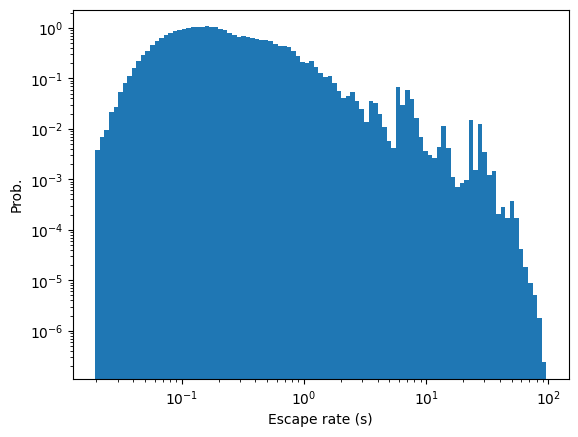

In [315]:
plt.figure()
plt.hist(all_escape_rates, bins=np.logspace(np.log10(min(all_escape_rates)), np.log10(max(all_escape_rates)), 100), density=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Escape rate (s)')
plt.ylabel('Prob.')
plt.show()

C:\Users\Suber\AppData\Local\Temp\ipykernel_27728\2179206717.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


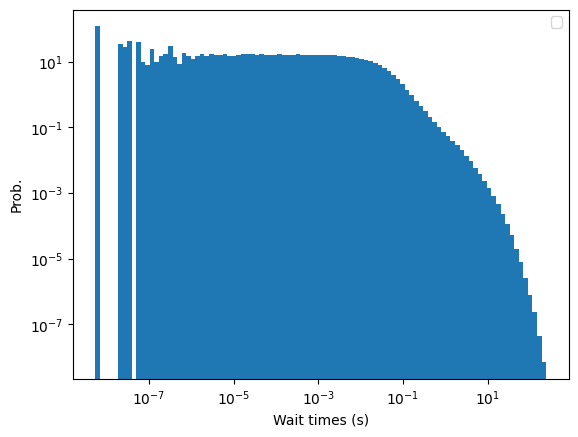

In [316]:
bins = np.logspace(np.log10(min(all_wait_times)), np.log10(max(all_wait_times)), 100)

plt.figure()
plt.hist(all_wait_times, bins=bins, density=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Wait times (s)")
plt.ylabel("Prob.")
plt.legend()
plt.show()

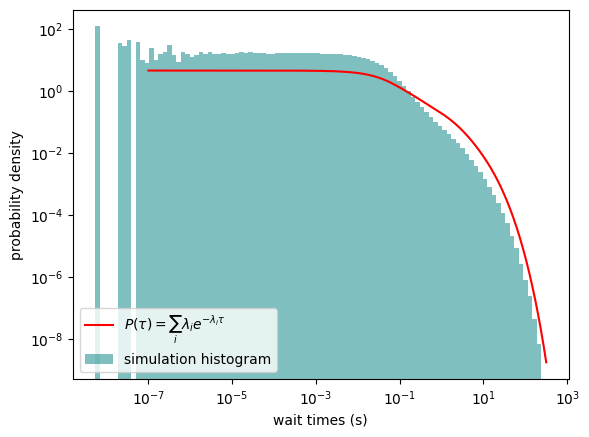

In [319]:
taus = np.logspace(-7, 2.5, 1000)

lambdas = np.array(all_escape_rates)
P_tau = np.mean(lambdas[:, None] * np.exp(-lambdas[:, None] * taus[None, :]), axis=0)
P_tau /= np.trapz(P_tau, taus)

plt.figure()
plt.plot(taus, P_tau, color='red', label=r'$P(\tau)=\sum_i \lambda_ie^{-\lambda_i\tau}$')
plt.hist(all_wait_times, bins=bins, density=True, color='teal', alpha=0.5, label='simulation histogram')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('wait times (s)')
plt.ylabel('probability density')
plt.legend()
plt.show()


alpha = 0.5756599847621208


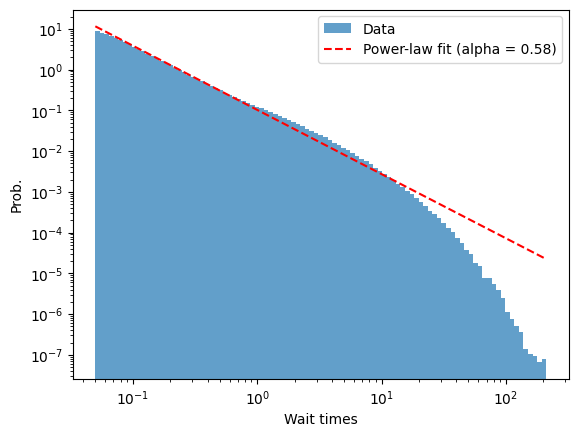

KS Statistic: 0.032545302246986596
p-value: 0.0


In [51]:
def fit_power_law_mle(data, x_min):
    
    data = np.array(data)
    data = data[data >= x_min]
    n = len(data)
    if n == 0:
        raise ValueError("No data above xmin")
    
    alpha = n / np.sum(np.log(data / x_min))
    return alpha

x_min = 0.05

alpha = fit_power_law_mle(all_wait_times, x_min)
print(f'alpha = {alpha}')

bins = np.logspace(np.log10(x_min), np.log10(max(all_wait_times)), 100)
x_vals = bins
y_vals = alpha *  x_min**alpha * x_vals**-(alpha+1)  # PDF

plt.figure()
plt.hist(all_wait_times, bins=bins, density=True, alpha=0.7, label="Data")
plt.plot(x_vals, y_vals, 'r--', label=f'Power-law fit (alpha = {np.round(alpha,2)})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Wait times")
plt.ylabel("Prob.")
plt.legend()
plt.show()

from scipy.stats import kstest

def power_law_cdf(x, alpha, x_min):
    return 1 - (x_min / x)**alpha


# Filter the data
data = np.array(all_wait_times)
data = data[data >= x_min]

# Perform KS test
D, p_value = kstest(data, lambda x: power_law_cdf(x, alpha, x_min))
print(f"KS Statistic: {D}")
print(f"p-value: {p_value}")

Fitted cutoff power-law: alpha = 0.429, x_min = 0.050, t_c = 19.958


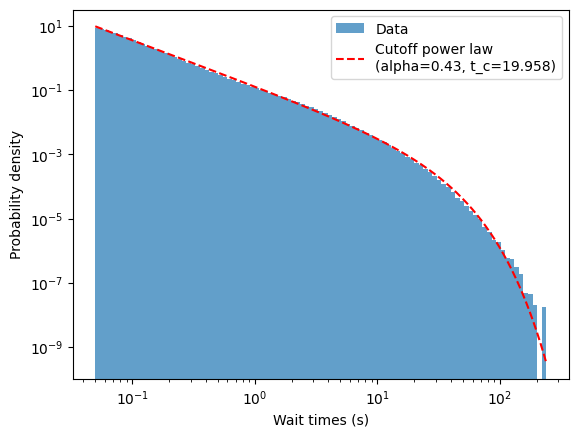

In [320]:
from scipy.optimize import minimize
from scipy.integrate import quad

def cutoff_powerlaw_pdf(x, alpha, t_c):
    return x**(-(alpha + 1)) * np.exp(-x / t_c)

def neg_log_likelihood(params, data, x_min):
    alpha, t_c = params
    if alpha <= 0 or t_c <= 0:
        return np.inf  

    integral, _ = quad(lambda x: x**(-(alpha + 1)) * np.exp(-x / t_c), x_min, np.inf)
    if integral == 0 or np.isnan(integral):
        return np.inf
    C = 1.0 / integral

    pdf_vals = C * cutoff_powerlaw_pdf(data, alpha, t_c)
    if np.any(pdf_vals <= 0):
        return np.inf 

    log_likelihood = np.sum(np.log(pdf_vals))
    return -log_likelihood  

def fit_cutoff_powerlaw(data, x_min):
    data = np.array(data)
    data = data[data >= x_min]
    if len(data) == 0:
        raise ValueError("No data above xmin")

    initial_guess = [0.5, np.mean(data)] 
    bounds = [(1e-2, 1), (1, 100)]

    result = minimize(neg_log_likelihood, initial_guess, args=(data, x_min), bounds=bounds)
    if not result.success:
        raise RuntimeError("Optimization failed")

    alpha, t_c = result.x
    return alpha, t_c, data



x_min = 5e-2
data = np.array(all_wait_times) 
alpha, t_c, data_filtered = fit_cutoff_powerlaw(data, x_min)
print(f"Fitted cutoff power-law: alpha = {alpha:.3f}, x_min = {x_min:.3f}, t_c = {t_c:.3f}")

bins = np.logspace(np.log10(x_min), np.log10(max(data_filtered)), 100)
plt.figure()
plt.hist(data_filtered, bins=bins, density=True, alpha=0.7, label="Data")

x_vals = np.logspace(np.log10(x_min), np.log10(max(data_filtered)), 500)
C, _ = quad(lambda x: x**(-(alpha + 1)) * np.exp(-x / t_c), x_min, np.inf)
pdf_vals = (1.0 / C) * cutoff_powerlaw_pdf(x_vals, alpha, t_c)

plt.plot(x_vals, pdf_vals, 'r--', label=f'Cutoff power law\n(alpha={alpha:.2f}, t_c={t_c:.3f})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Wait times (s)")
plt.ylabel("Probability density")
plt.legend()
plt.show()

alpha = 0.47


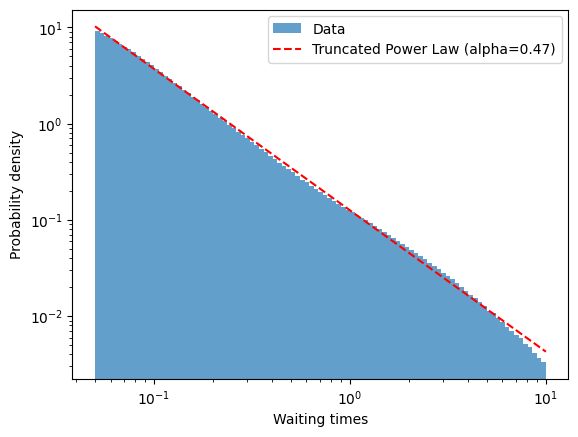

KS statistic: 0.0086
p-value: 0.0000


In [54]:
from scipy.optimize import minimize_scalar
from scipy.stats import kstest

def neg_log_likelihood(alpha, data, x_min, x_max):
    if alpha <= 0:
        return np.inf  # alpha must be positive

    n = len(data)
    sum_log_x = np.sum(np.log(data))
    C = x_min**(-alpha) - x_max**(-alpha)
    
    neg_ll = -n * np.log(alpha) + (alpha + 1) * sum_log_x + n * np.log(C)
    return neg_ll

def fit_truncated_power_law(data, x_min, x_max):
    data = np.array(data)
    data = data[(data >= x_min) & (data <= x_max)]
    if len(data) == 0:
        raise ValueError("No data in the specified range")

    # Minimize negative log-likelihood over alpha > 0
    res = minimize_scalar(neg_log_likelihood, bounds=(1e-5, 10), method='bounded',
                          args=(data, x_min, x_max))
    if not res.success:
        raise RuntimeError("MLE optimization failed")
    alpha_hat = res.x
    return alpha_hat, data

def truncated_power_law_pdf(x, alpha, x_min, x_max):
    C = x_min**(-alpha) - x_max**(-alpha)
    return ( alpha * x**(-(alpha + 1)) ) / C

def truncated_power_law_cdf(x, alpha, x_min, x_max):
    C = x_min**(-alpha) - x_max**(-alpha)
    cdf = (x_min**(-alpha) - x**(-alpha)) / C
    cdf = np.clip(cdf, 0, 1)
    return cdf

x_min = 0.05
x_max = 10

alpha, filtered_data = fit_truncated_power_law(all_wait_times, x_min, x_max)
print(f"alpha = {np.round(alpha, 2)}")

bins = np.logspace(np.log10(x_min), np.log10(x_max), 100)
plt.figure()
plt.hist(filtered_data, bins=bins, density=True, alpha=0.7, label='Data')

x_vals = np.logspace(np.log10(x_min), np.log10(x_max), 500)
pdf_vals = truncated_power_law_pdf(x_vals, alpha, x_min, x_max)
plt.plot(x_vals, pdf_vals, 'r--', label=f'Truncated Power Law (alpha={np.round(alpha, 2)})')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Waiting times')
plt.ylabel('Probability density')
plt.legend()
plt.show()

D, p_value = kstest(filtered_data, lambda x: truncated_power_law_cdf(x, alpha, x_min, x_max))
print(f"KS statistic: {D:.4f}")
print(f"p-value: {p_value:.4f}")
#Because we got alpha by fitting to the data, when we compute the KS statistic, it is suspiciously low (the fit is too good),
#so the p-value is low. Must use bootstrapping.

Fitted alpha on training data: 0.5481
Cramér–von Mises statistic on test data: 0.4759
Bootstrap p-value: 0.0480


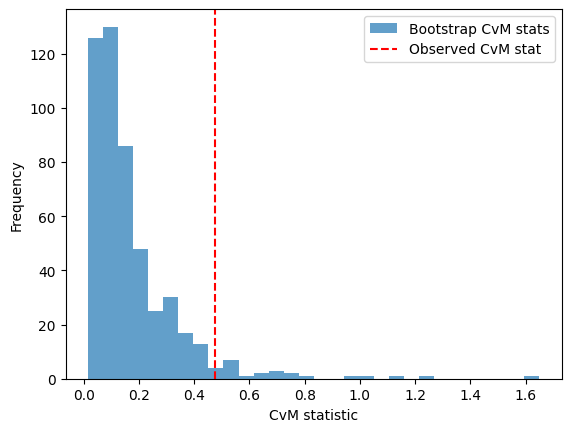

In [34]:
#This just uses the fact that for u = Uniform(0,1), p(x) = F^-1(u) where F is the CDF of p(x)
def sample_truncated_power_law(alpha, x_min, x_max, size):
    u = np.random.uniform(0,1,size)
    C = x_min**(-alpha) - x_max**(-alpha)
    samples = (x_min**(-alpha) - u * C) ** (-1/alpha)
    return samples

def sample_truncated_power_law_with_noise(alpha, x_min, x_max, size, noise_std=0.05):
    samples = sample_truncated_power_law(alpha, x_min, x_max, size)
    noise = np.random.normal(1.0, noise_std, size)
    noisy_samples = samples * noise
    return np.clip(noisy_samples, x_min, x_max)  # keep within bounds

def bootstrap_ks(data, x_min, x_max, n_bootstrap):

    alpha_hat, filtered_data = fit_truncated_power_law(data, x_min, x_max)
    n = len(filtered_data)

    D_orig, _ = kstest(
        filtered_data,
        lambda x: truncated_power_law_cdf(x, alpha_hat, x_min, x_max)
    )

    ks_stats = []

    for _ in range(n_bootstrap):
        # 1. Simulate synthetic dataset from fitted model
        synthetic_data = sample_truncated_power_law_with_noise(alpha_hat, x_min, x_max, n)

        # 2. Fit model to synthetic dataset (refit!)
        try:
            alpha_star, _ = fit_truncated_power_law(synthetic_data, x_min, x_max)
        except RuntimeError:
            continue  # skip this bootstrap if fitting fails

        # 3. Compute KS statistic for synthetic vs refitted model
        D_star, _ = kstest(
            synthetic_data,
            lambda x: truncated_power_law_cdf(x, alpha_star, x_min, x_max)
        )
        ks_stats.append(D_star)

    ks_stats = np.array(ks_stats)
    p_value_boot = np.mean(ks_stats >= D_orig)

    return alpha_hat, filtered_data, D_orig, p_value_boot, ks_stats
        
# x_min = 2e-1
# x_max = 5
# n_bootstrap = 50

# alpha, filtered_data, D_orig, p_value_boot, ks_stats = bootstrap_ks(all_wait_times, x_min, x_max, n_bootstrap)

# print(f"Original KS statistic: {D_orig:.4f}")
# print(f"Bootstrap p-value: {p_value_boot:.4f}")

import numpy as np
from scipy.optimize import minimize_scalar
from scipy.stats import cramervonmises
import matplotlib.pyplot as plt

# Your existing functions: neg_log_likelihood, fit_truncated_power_law, truncated_power_law_cdf

def split_train_test(data, train_frac=0.7, random_seed=None):
    np.random.seed(random_seed)
    data = np.array(data)
    shuffled = np.random.permutation(data)
    n_train = int(len(data) * train_frac)
    return shuffled[:n_train], shuffled[n_train:]

def sample_truncated_power_law(alpha, x_min, x_max, size):
    u = np.random.uniform(0, 1, size)
    C = x_min**(-alpha) - x_max**(-alpha)
    samples = (x_min**(-alpha) - u * C) ** (-1/alpha)
    return samples

def compute_cvm_statistic(data, alpha, x_min, x_max):
    # Filter data inside range
    data = data[(data >= x_min) & (data <= x_max)]
    # Compute CDF values at data points
    cdf_vals = truncated_power_law_cdf(data, alpha, x_min, x_max)
    # Use scipy's cramervonmises with known CDF values, approximate with 'cdf' as uniform
    # So just calculate the CvM statistic manually here:
    n = len(data)
    sorted_cdf = np.sort(cdf_vals)
    i = np.arange(1, n + 1)
    W2 = np.sum((sorted_cdf - (2*i - 1) / (2*n)) ** 2) + 1/(12*n)
    return W2

def bootstrap_cvm_pvalue(train_data, test_data, x_min, x_max, n_bootstrap=500):
    # Fit on training data
    alpha_hat, train_filtered = fit_truncated_power_law(train_data, x_min, x_max)
    
    # Compute observed CvM stat on test data
    W2_obs = compute_cvm_statistic(test_data, alpha_hat, x_min, x_max)
    
    n_test = len(test_data[(test_data >= x_min) & (test_data <= x_max)])
    
    bootstrap_stats = []
    for _ in range(n_bootstrap):
        # Generate synthetic bootstrap training data
        synthetic_train = sample_truncated_power_law(alpha_hat, x_min, x_max, len(train_filtered))
        # Fit parameters to synthetic training data
        alpha_boot, _ = fit_truncated_power_law(synthetic_train, x_min, x_max)
        # Generate synthetic test data from bootstrap fit with test sample size
        synthetic_test = sample_truncated_power_law(alpha_boot, x_min, x_max, n_test)
        # Compute CvM stat on synthetic test data
        W2_boot = compute_cvm_statistic(synthetic_test, alpha_boot, x_min, x_max)
        bootstrap_stats.append(W2_boot)
    
    bootstrap_stats = np.array(bootstrap_stats)
    # p-value = fraction of bootstrap stats greater or equal to observed
    p_value = np.mean(bootstrap_stats >= W2_obs)
    
    return alpha_hat, W2_obs, p_value, bootstrap_stats

# Example usage:
x_min = 0.1
x_max = 0.5
train_data, test_data = split_train_test(all_wait_times, train_frac=0.7, random_seed=42)

alpha_hat, W2_obs, p_value, bootstrap_stats = bootstrap_cvm_pvalue(train_data, test_data, x_min, x_max, n_bootstrap=500)

print(f"Fitted alpha on training data: {alpha_hat:.4f}")
print(f"Cramér–von Mises statistic on test data: {W2_obs:.4f}")
print(f"Bootstrap p-value: {p_value:.4f}")

# Optional: visualize bootstrap distribution vs observed stat
plt.hist(bootstrap_stats, bins=30, alpha=0.7, label='Bootstrap CvM stats')
plt.axvline(W2_obs, color='r', linestyle='--', label='Observed CvM stat')
plt.xlabel('CvM statistic')
plt.ylabel('Frequency')
plt.legend()
plt.show()

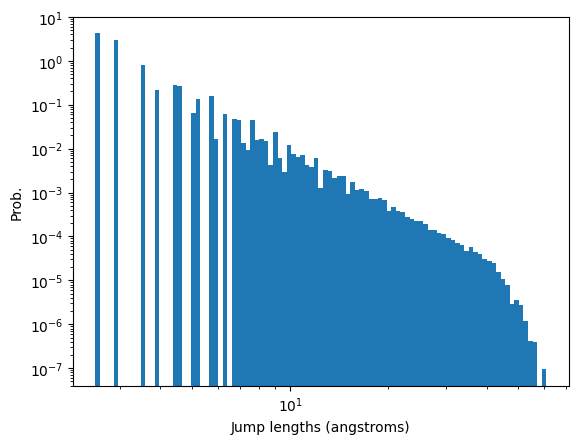

In [321]:
plt.figure()
bins = np.logspace(np.log10(min(all_jump_lengths)), np.log10(max(all_jump_lengths)), 100)
plt.hist(all_jump_lengths, bins=bins, density=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Jump lengths (angstroms)")
plt.ylabel("Prob.")
plt.show()

In [59]:
rounded = np.round(all_jump_lengths, decimals=2)
print(np.unique(rounded)[0:19])

[2.52 2.96 3.57 3.89 4.37 4.64 5.05 5.28 5.64 5.85 6.37 6.68 6.86 7.14
 7.31 7.57 7.73 7.98 8.13]


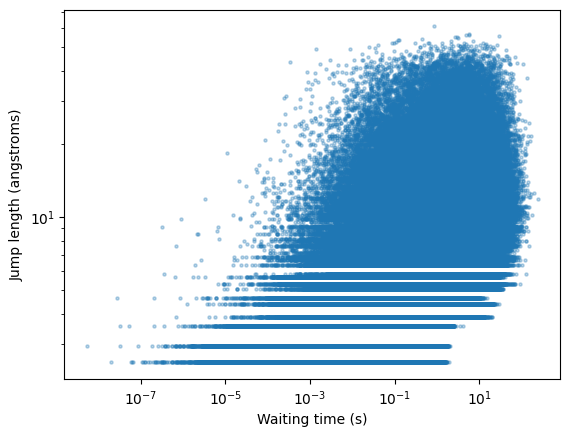

Log-log correlation coefficient between waiting time and jump length: 0.612


In [322]:
wait_times = np.array(all_wait_times)
jump_lengths = np.array(all_jump_lengths)

plt.figure()
plt.scatter(wait_times, jump_lengths, alpha=0.3, s=5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Waiting time (s)')
plt.ylabel('Jump length (angstroms)')
# plt.grid(True, which='both')
plt.show()

# Compute correlation coefficient on log-scale
log_tau = np.log(wait_times + 1e-12)  # avoid log(0)
log_d = np.log(jump_lengths + 1e-12)

corr_coef = np.corrcoef(log_tau, log_d)[0,1]
print(f"Log-log correlation coefficient between waiting time and jump length: {corr_coef:.3f}")

C:\Users\Suber\AppData\Local\Temp\ipykernel_27728\1751312288.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('wait_bin')['jump'].mean()


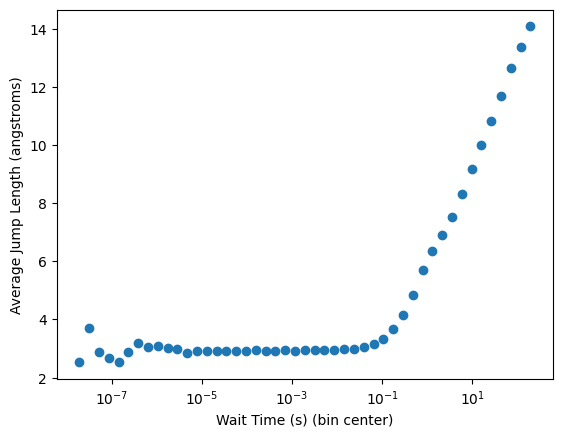

In [326]:
import pandas as pd

df = pd.DataFrame({
    'wait': wait_times,
    'jump': jump_lengths
})

# Logarithmic bins for wait times
bins = np.logspace(np.log10(df['wait'].min()), np.log10(df['wait'].max()), num=50)
df['wait_bin'] = pd.cut(df['wait'], bins=bins)

# Group by non-empty bins and compute mean jump length
grouped = df.groupby('wait_bin')['jump'].mean()

# Get bin centers only for bins with data
bin_centers = grouped.index.to_series().apply(lambda x: x.mid)

plt.scatter(bin_centers, grouped.values)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Wait Time (s) (bin center)')
plt.ylabel('Average Jump Length (angstroms)')
plt.show()

Fitted parameters:
 C=3.068, A=3.8, alpha=0.2103, x_c=0.6389


C:\Users\Suber\AppData\Local\Temp\ipykernel_27728\3860440774.py:14: RuntimeWarning: invalid value encountered in power
  return np.where(x < x_c, C, C + A * (x - x_c)**alpha)


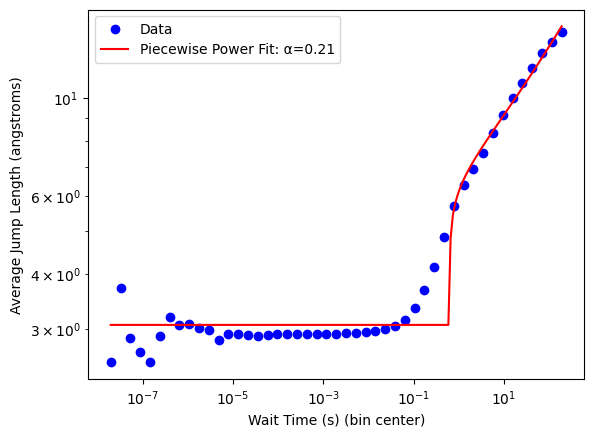

In [334]:
from scipy.optimize import curve_fit

avg_jump_lengths = grouped.values

xdata = np.array(bin_centers)
ydata = np.array(avg_jump_lengths)

# Clean the data to remove NaNs or infs
mask = np.isfinite(xdata) & np.isfinite(ydata)
xdata_clean = xdata[mask]
ydata_clean = ydata[mask]

def piecewise_power(x, C, A, alpha, x_c):
    return np.where(x < x_c, C, C + A * (x - x_c)**alpha)

initial_guess = [3, 3.0, 0.3, 0.3]

popt, pcov = curve_fit(piecewise_power, xdata_clean, ydata_clean, p0=initial_guess)

C_fit, A_fit, alpha_fit, x_c_fit = popt
print(f"Fitted parameters:\n C={C_fit:.4g}, A={A_fit:.4g}, alpha={alpha_fit:.4g}, x_c={x_c_fit:.4g}")

x_fit = np.logspace(np.log10(min(xdata_clean)), np.log10(max(xdata_clean)), 200)
y_fit = piecewise_power(x_fit, *popt)

plt.scatter(xdata_clean, ydata_clean, label='Data', color='blue')
plt.plot(x_fit, y_fit, label=f'Piecewise Power Fit: α={alpha_fit:.2f}', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wait Time (s) (bin center)')
plt.ylabel('Average Jump Length (angstroms)')
plt.legend()
plt.show()

Tail Fit:
 A=5.836, alpha=0.1784


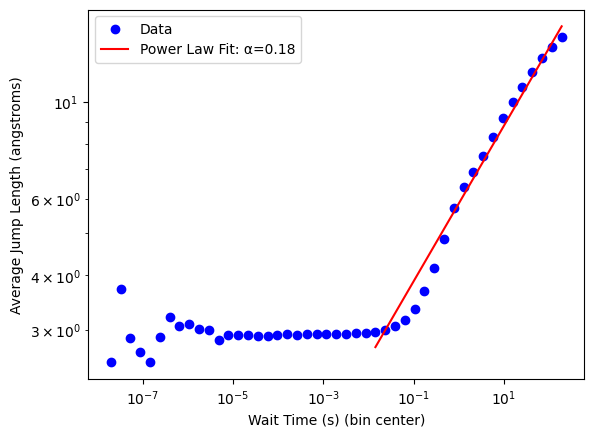

In [332]:
x_cutoff = 1e-2

tail_mask = xdata_clean > x_cutoff
x_tail = xdata_clean[tail_mask]
y_tail = ydata_clean[tail_mask]

def pure_power(x, A, alpha):
    return A * x**alpha

popt, pcov = curve_fit(pure_power, x_tail, y_tail, p0=[1.0, 0.2])
A_fit, alpha_fit = popt

print(f"Tail Fit:\n A={A_fit:.4g}, alpha={alpha_fit:.4g}")

x_fit = np.logspace(np.log10(min(x_tail)), np.log10(max(x_tail)), 200)
y_fit = pure_power(x_fit, *popt)

plt.scatter(xdata_clean, ydata_clean, label='Data', color='blue')
plt.plot(x_fit, y_fit, label=f'Power Law Fit: α={alpha_fit:.2f}', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wait Time (s) (bin center)')
plt.ylabel('Average Jump Length (angstroms)')
plt.legend()
plt.show()

In [335]:
def wrap_positions(positions, size):
    box_size = 3.57 * (2*size + 1)
    pos_wrapped = positions.copy()
    pos_wrapped[pos_wrapped >= box_size / 2] -= box_size
    pos_wrapped[pos_wrapped < -box_size / 2] += box_size
    return pos_wrapped

def periodic_distance(r1, r2, size):
    box_size = 3.57 * (2*size + 1)
    diff = r2 - r1
    diff_wrapped = diff - box_size * np.round(diff / box_size)
    dist = np.linalg.norm(diff_wrapped)
#     if dist > box_size / 2:
#         print(f"Before wrapping diff: {diff}")
#         print(f"After wrapping diff: {diff_wrapped}")
#         print(f"Box size: {box_size}")
#         print(f"Large jump detected: dist={dist:.3f}, r1={r1}, r2={r2}, diff={diff_wrapped}")
    return dist

def pad(data):
    x = len(data)
    y = max(len(arr) for arr in data)
    padded_data = np.full((x, y), np.nan)
    for i in range(x):
        padded_data[i, :len(data[i])] = data[i]
    return padded_data
    

def contribution_threshold(data, cutoff_fraction):
    data_arr = np.array(data)
    n_trajectories = data_arr.shape[0]
    min_required = int(cutoff_fraction * n_trajectories)  #90% cutoff
    valid_counts = np.sum(~np.isnan(data), axis=0)
    cutoff_idx = np.where(valid_counts < min_required)[0]
    if len(cutoff_idx) > 0:
        last_valid_idx = cutoff_idx[0]
    else:
        last_valid_idx = data_arr.shape[1]
        
    return last_valid_idx


def gillespie(size, W, positions, t_max):
    
    N = W.shape[0]
    site = np.random.randint(N)
    time = 0 

    sites = [site]
    wait_times = []
    times = [0]
    
    while time < t_max:
        rates = W[:, site]
        total_rate = -W[site, site]
        
        tau = np.random.exponential(1 / total_rate)
        time += tau

        probs = rates.copy()
        probs[site] = 0 #No self-hopping
        probs /= total_rate
        next_site = np.random.choice(N, p=probs)
        
        wait_times.append(tau)
        sites.append(next_site)
        times.append(time)
        
        site = next_site
    
    jump_lengths = [periodic_distance(positions[sites[i+1]], positions[sites[i]], size) for i in range(len(sites) - 1)]
    squared_displacements = [periodic_distance(positions[sites[i]], positions[sites[0]], size)**2 for i in range(len(sites))]
    
    visited = set()
    distinct_sites = []
    for site in sites:
        visited.add(site)
        distinct_sites.append(len(visited))
    
    return wait_times, jump_lengths, times, squared_displacements, distinct_sites, sites


def ensemble_average(size, W, positions, t_max, n_trajectories):
    
    all_wait_times = []
    all_jump_lengths = []
    
    max_steps = 0
    all_times = []
    all_squared_displacements = []
    
    all_distinct_sites = []
    all_sites = []
    
    for _ in range(n_trajectories):
        wait_times, jump_lengths, times, sq_disp, distinct_sites, sites = gillespie(size, W, positions, t_max)
        
        all_wait_times.extend(wait_times)
        all_jump_lengths.extend(jump_lengths)
        
        all_times.append(times)
        all_squared_displacements.append(sq_disp)
        
        all_distinct_sites.append(distinct_sites)
        all_sites.append(sites)
        
    padded_disp = pad(all_squared_displacements)
    msd_vs_steps = np.nanmean(padded_disp, axis=0)
    last_valid_idx = contribution_threshold(padded_disp, 0.8)
    msd_vs_steps = msd_vs_steps[:last_valid_idx]

#     valid_counts = np.sum(~np.isnan(padded_disp), axis=0)
#     plt.plot(valid_counts)
#     plt.xlabel("Step number")
#     plt.ylabel("Number of trajectories contributing")
#     plt.title("Trajectory contributions per step")
#     plt.show()
    from scipy.interpolate import interp1d

    t_bins = np.linspace(0, t_max, last_valid_idx)
    all_interp_disp = []
    for times, sq_disp in zip(all_times, all_squared_displacements):
        times = np.array(times)
        sq_disp = np.array(sq_disp)
        valid_times_mask = times <= t_max
        
        f = interp1d(times[valid_times_mask], sq_disp[valid_times_mask], kind='previous', bounds_error=False, fill_value=np.nan)
        interp_disp = f(t_bins)
        all_interp_disp.append(interp_disp)

    msd_vs_time = np.nanmean(all_interp_disp, axis=0)
    
#     valid_counts = np.sum(~np.isnan(all_interp_disp), axis=0)
#     plt.plot(t_bins, valid_counts, marker='o')
#     plt.axhline(90)
#     plt.xlabel("Time")
#     plt.ylabel("Number of trajectories contributing")
#     plt.title("Trajectory count per time bin (MSD vs Time)")

    last_valid_idx = contribution_threshold(all_interp_disp, 0.8)
    t_bins = t_bins[:last_valid_idx]
    msd_vs_time = msd_vs_time[:last_valid_idx]
    
    padded_distinct_sites = pad(all_distinct_sites)
    distinct_sites_vs_steps = np.nanmean(padded_distinct_sites, axis=0)
    last_valid_idx = contribution_threshold(padded_distinct_sites, 0.8)
    distinct_sites_vs_steps = distinct_sites_vs_steps[:last_valid_idx]

    return all_wait_times, all_jump_lengths, msd_vs_steps, t_bins, msd_vs_time, distinct_sites_vs_steps, all_times, all_sites


def config_average(size, t_max, n_trajectories, n_configs):
    
    all_wait_times = []
    all_jump_lengths = []
    
    all_msd_vs_steps = []
    all_t_bins = []
    all_msd_vs_time = []
    
    all_distinct_sites = []
    all_sites = []
    all_times = []
    
    for _ in tqdm(range(n_configs)):
        
        carbon_pts, _ = sample_special_positions(3.57, size, 1.1e-2, 0)
        wrapped_carbon_pts = wrap_positions(carbon_pts, size)
        W = calculate_W(size, wrapped_carbon_pts, 2.5e-5)
        
        wait_times, jump_lengths, msd_vs_steps, t_bins, msd_vs_time, distinct_sites, times, sites = ensemble_average(
            size, W, wrapped_carbon_pts, t_max, n_trajectories
        )
        
        all_wait_times.extend(wait_times)
        all_jump_lengths.extend(jump_lengths)
        
        all_msd_vs_steps.append(msd_vs_steps)
        all_t_bins.append(t_bins)
        all_msd_vs_time.append(msd_vs_time)
        
        all_distinct_sites.append(distinct_sites)
        all_sites.append(sites)
        all_times.append(times)
        
    padded_msd = pad(all_msd_vs_steps)
    msd_vs_steps_avg = np.nanmean(padded_msd, axis=0)
    last_valid_idx = contribution_threshold(padded_msd, 0.8)
    msd_vs_steps_avg = msd_vs_steps_avg[:last_valid_idx]
    
    padded_t_bins = pad(all_t_bins)
    t_bins_avg = np.nanmean(padded_t_bins, axis=0)
    padded_time_disp = pad(all_msd_vs_time)
    msd_vs_time_avg = np.nanmean(padded_time_disp, axis=0)
    last_valid_idx = contribution_threshold(padded_time_disp, 0.8)
    t_bins_avg = t_bins_avg[:last_valid_idx]
    msd_vs_time_avg = msd_vs_time_avg[:last_valid_idx]
    
    padded_distinct_sites = pad(all_distinct_sites)
    distinct_sites_avg = np.nanmean(padded_distinct_sites, axis=0)
    last_valid_idx = contribution_threshold(padded_distinct_sites, 0.8)
    distinct_sites_avg = distinct_sites_avg[:last_valid_idx]

    return all_wait_times, all_jump_lengths, msd_vs_steps_avg, t_bins_avg, msd_vs_time_avg, distinct_sites_avg, \
           all_times, all_sites

In [336]:
from tqdm import tqdm
from scipy.interpolate import interp1d
import time
start_time = time.time()

size = 16
t_max = 200
n_trajectories = 1000
n_configs = 100

all_wait_times, all_jump_lengths, msd_vs_steps, t_bins, msd_vs_time, distinct_sites_avg, all_times, all_sites = config_average(
    size, t_max, n_trajectories, n_configs
)

end_time = time.time()
print(end_time-start_time)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Suber\AppData\Local\Temp\ipykernel_27728\1065765651.py:131: RuntimeWarning: Mean of empty slice
  msd_vs_time = np.nanmean(all_interp_disp, axis=0)
100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [2:51:43<00:00, 103.03s/it]

10303.211348772049


box_size = 117.810
box_size_squared = 13879.196


C:\Users\Suber\AppData\Local\Temp\ipykernel_27728\3552635095.py:9: RuntimeWarning: divide by zero encountered in power
  return A * x**alpha


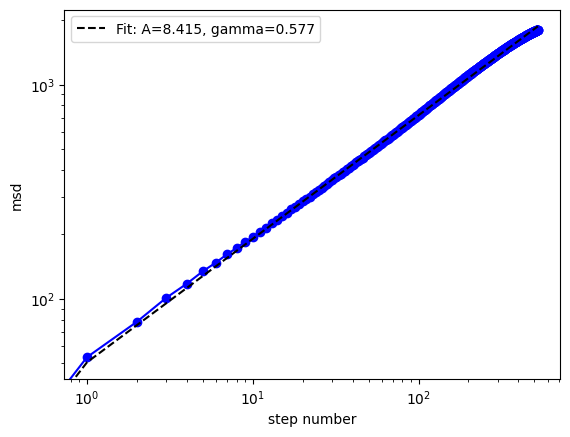

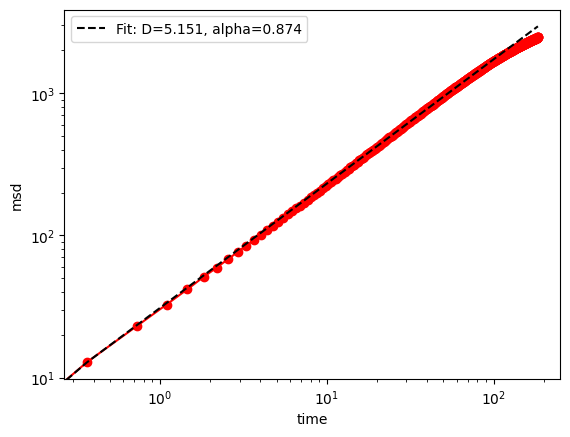

In [338]:
# Important note: if you run the simulation for a short time and look at msd vs steps, most of the points with higher
# steps will only have 1 or 2 trajectories contributing, making the result super noisy
print(f'box_size = {3.57 * (2*size + 1):.3f}')
print(f'box_size_squared = {(3.57 * (2*size + 1))**2:.3f}')

from scipy.optimize import curve_fit

def power_law(x, A, alpha):
    return A * x**alpha

n_steps = np.arange(0, len(msd_vs_steps))

n_cutoff = np.where(n_steps > 100)[0][0]
t_cutoff = np.where(t_bins > 80)[0][0]

popt, pcov = curve_fit(power_law, n_steps[:n_cutoff], msd_vs_steps[:n_cutoff], p0=[1, 1])
A_fit, gamma_fit = popt

popt, pcov = curve_fit(power_law, t_bins[:t_cutoff], msd_vs_time[:t_cutoff], p0=[1, 1]) 
D_fit, alpha_fit = popt

plt.figure()
plt.plot(n_steps, msd_vs_steps, marker='o', color='b')
plt.plot(n_steps, power_law(n_steps, A_fit, gamma_fit), 'k--', label=f'Fit: A={A_fit/6:.3f}, gamma={gamma_fit:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('step number')
plt.ylabel('msd')
plt.legend()
plt.show()
    
plt.figure()
plt.plot(t_bins, msd_vs_time, marker='o', color='r')
plt.plot(t_bins, power_law(t_bins, D_fit, alpha_fit), 'k--', label=f'Fit: D={D_fit/6:.3f}, alpha={alpha_fit:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time')
plt.ylabel('msd')
plt.legend()
plt.show()

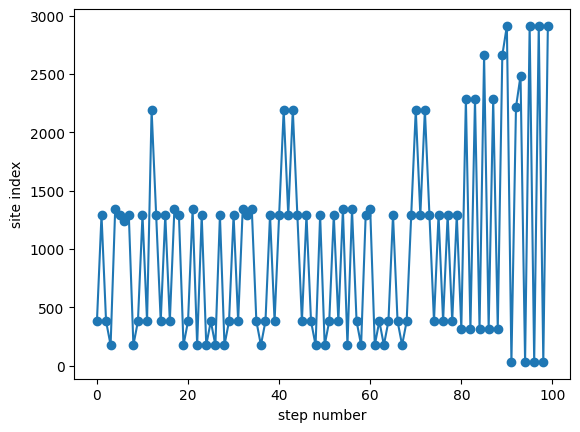

In [343]:
all_sites_flat = [traj for config in all_sites for traj in config]
max_trajectories = 1
# plt.figure()
for i, sites in enumerate(all_sites_flat[:max_trajectories]):
    plt.figure()
    steps = range(len(sites))
    plt.plot(steps[:100], sites[:100], marker='o', linestyle='-', label=f'Traj {i+1}')
    plt.xlabel('step number')
    plt.ylabel('site index')
plt.show()

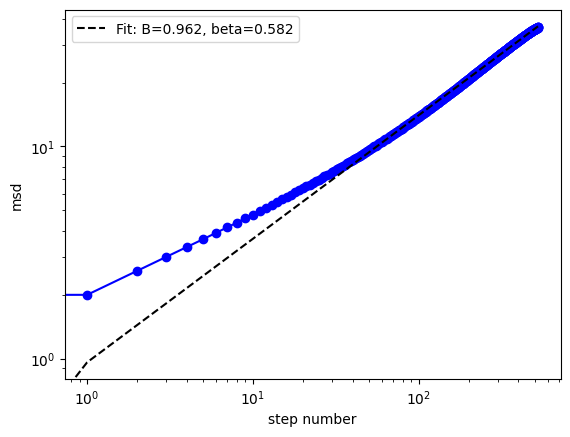

In [344]:
popt, pcov = curve_fit(power_law, n_steps, distinct_sites_avg, p0=[1, 1]) 
B_fit, beta_fit = popt

plt.figure()
plt.plot(n_steps, distinct_sites_avg, marker='o', color='b')
plt.plot(n_steps, power_law(n_steps, B_fit, beta_fit), 'k--', label=f'Fit: B={B_fit:.3f}, beta={beta_fit:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('step number')
plt.ylabel('msd')
plt.legend()
plt.show()

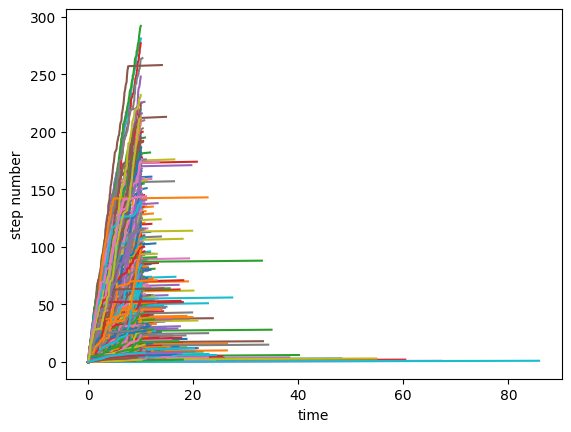

In [506]:
all_times_flat = [traj for config in all_times for traj in config]
all_sites_flat = [traj for config in all_sites for traj in config]
plt.figure()
for times, sites in zip(all_times_flat, all_sites_flat):
    steps = np.arange(len(sites))
    plt.plot(times, steps)
plt.xlabel('time')
plt.ylabel('step number')
plt.show()

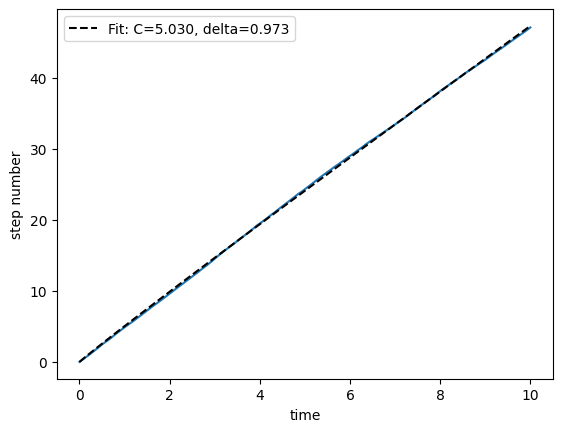

In [505]:
t_bins = np.linspace(0, t_max, 100)
all_interp_steps = []

for times, sites in zip(all_times_flat, all_sites_flat):
    times = np.array(times)
    steps = np.arange(len(sites))
    valid_times_mask = times <= t_max

    f = interp1d(times, steps, kind='previous', bounds_error=False, fill_value=np.nan)
    interp_steps = f(t_bins)
    all_interp_steps.append(interp_steps)
    
steps_avg = np.nanmean(all_interp_steps, axis=0)
last_valid_idx = contribution_threshold(all_interp_steps, 0.1)
t_bins = t_bins[:last_valid_idx]
steps_avg = steps_avg[:last_valid_idx]

popt, pcov = curve_fit(power_law, t_bins, steps_avg, p0=[1, 1]) 
C_fit, delta_fit = popt

plt.figure()
plt.plot(t_bins, steps_avg)
plt.plot(t_bins, power_law(t_bins, C_fit, delta_fit), 'k--', label=f'Fit: C={C_fit:.3f}, delta={delta_fit:.3f}')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('time')
plt.ylabel('step number')
plt.legend()
plt.show()

In [24]:
#Simulate "Levy walk with rests"
from tqdm import tqdm

alpha = 0.4       # Power-law exponent for waiting time: psi(tau) ~ tau^-(1 + alpha)
beta = 0.2        # Coupling exponent: jump_length ~ tau^beta
tau_min = 1e-8    # Minimum waiting time
tau_max = 200     # Maximum waiting time
n_trajectories = 10000
t_max = 200
n_timepoints = 100

time_grid = np.linspace(2, t_max, n_timepoints)

def sample_tau(alpha, tau_min, tau_max):
    while True:
        u = np.random.uniform()
        tau = tau_min * (1 - u) ** (-1 / alpha)
        if tau < tau_max:
            return tau
        
def jump_length(tau, C, A, alpha, x_c):
    if tau < x_c:
        return 0
    else:
        delta = tau - x_c
        return (C + A * delta**alpha) * np.random.choice([-1, 1])

positions_interp = np.zeros((n_trajectories, n_timepoints))

for i in tqdm(range(n_trajectories)):
    t = 0.0
    x = 0.0
    times = [0]
    positions = [0]
    
    while t < t_max:
        tau = sample_tau(alpha, tau_min, tau_max)
        
        hop_length = jump_length(tau, C=3, A=4, alpha=0.2, x_c=0.6)

        t += tau
        x += hop_length
        
        times.append(t)
        positions.append(x)

    interp_x = np.interp(time_grid, times, positions, left=0, right=positions[-1])
    positions_interp[i] = interp_x

msd = np.mean(positions_interp**2, axis=0)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:33<00:00, 19.47it/s]


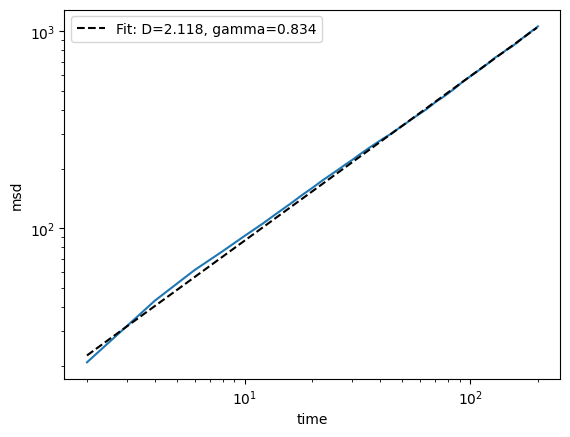

In [27]:
def power_law(x, A, alpha):
    return A * x**alpha

t_cutoff = np.where(time_grid > 199)[0][0]

popt, pcov = curve_fit(power_law, time_grid[:t_cutoff], msd[:t_cutoff], p0=[1, 1])
D_fit, gamma_fit = popt

plt.figure()
plt.loglog(time_grid, msd)
plt.loglog(time_grid[:t_cutoff], power_law(time_grid[:t_cutoff], D_fit, gamma_fit), 'k--', label=f'Fit: D={D_fit/6:.3f}, gamma={gamma_fit:.3f}')
plt.xlabel('time')
plt.ylabel('msd')
plt.legend()
plt.show()

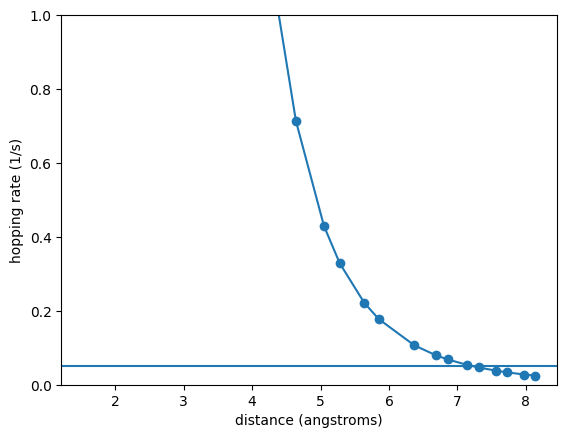

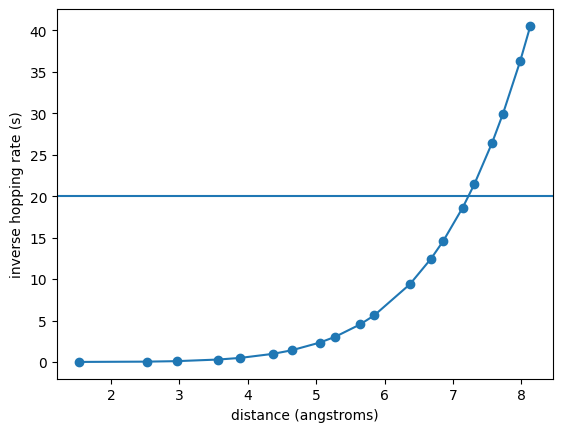

In [345]:
mu_0 = 1.256e-6  
hbar = 1.055e-34  
gamma_C = 10.7084e6  
tau_d = 2.5e-5  

distances = [
 1.54, 2.52, 2.96, 3.57, 3.89, 4.37, 4.64, 5.05, 5.28, 5.64, 5.85, 6.37, 6.68, 6.86, 7.14, 
 7.31, 7.57, 7.73, 7.98, 8.13
]


rates = np.zeros(len(distances))
A = 1 
for i in range(len(distances)):
    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (distances[i] * 1e-10)**3)
    rates[i] = B**2 * 0.5 * tau_d

plt.figure()
plt.plot(distances, rates, '-o')
plt.xlabel('distance (angstroms)')
plt.ylabel('hopping rate (1/s)')
plt.axhline(5e-2)
plt.ylim(0, 1)
plt.show()

plt.figure()
plt.plot(distances, 1 / rates, '-o')
plt.xlabel('distance (angstroms)')
plt.ylabel('inverse hopping rate (s)')
plt.axhline(1 / 5e-2)
plt.show()


In [618]:
import networkx as nx

size = 11
carbon_pts, _ = sample_special_positions(3.57, size, 1.1e-2, 0)
wrapped_carbon_pts = wrap_positions(carbon_pts, size)
W = calculate_W(size, wrapped_carbon_pts, 2.5e-5)

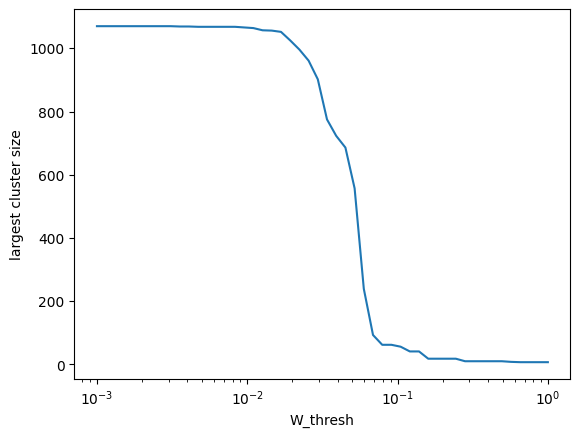

In [619]:
thresholds = np.logspace(-3, 0, 50)
largest_sizes = []
for thresh in thresholds:
    A = (W > thresh).astype(int)
    G = nx.from_numpy_array(A)
    components = list(nx.connected_components(G))
    largest = max(components, key=len)
    largest_sizes.append(len(largest))

plt.semilogx(thresholds, largest_sizes)
plt.xlabel("W_thresh")
plt.ylabel("largest cluster size")
plt.show()

In [620]:
W_thresh = 5e-2
adj_matrix = (W > W_thresh).astype(int)
G = nx.from_numpy_array(adj_matrix)
components = list(nx.connected_components(G))
print(f"Number of connected components: {len(components)}")
largest = max(components, key=len)
print(f"Largest component size: {len(largest)}/{len(W)}")

Number of connected components: 158
Largest component size: 557/1070


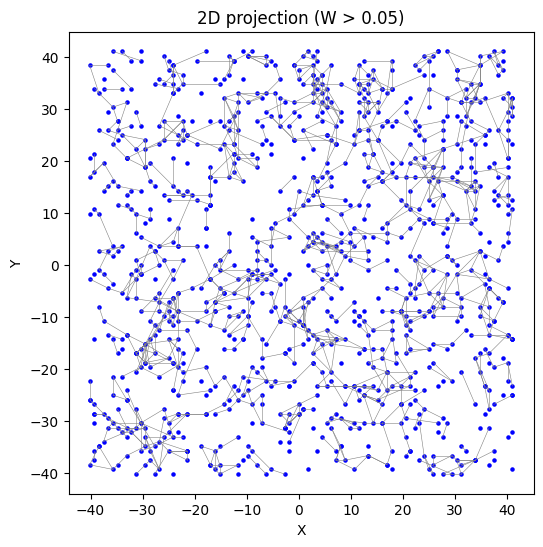

In [621]:
box_size = 3.57 * (2 * size + 1)
positions = wrapped_carbon_pts
xs, ys, zs = positions[:, 0], positions[:, 1], positions[:, 2]

# W_thresh = 5e-2
# adj_matrix = (W > W_thresh).astype(int)
# G = nx.from_numpy_array(adj_matrix)

fig, ax = plt.subplots(figsize=(6, 6))

for i, j in G.edges():
    pos_i = positions[i]
    pos_j = positions[j]

    delta = pos_i - pos_j
    delta_wrapped = delta - box_size * np.round(delta / box_size)

    # Euclidean distances
    dist_actual = np.linalg.norm(delta)
    dist_wrapped = np.linalg.norm(delta_wrapped)

    # Only plot if no wrapping was needed (i.e., edge didn't go across boundary)
    if np.isclose(dist_actual, dist_wrapped, atol=1e-6):  # can adjust tolerance
        ax.plot([pos_i[0], pos_j[0]], [pos_i[1], pos_j[1]], color='gray', linewidth=0.4)

# Draw nodes
xs, ys = positions[:, 0], positions[:, 1]
ax.scatter(xs, ys, c='blue', s=5)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title(f"2D projection (W > {W_thresh})")
plt.axis('equal')
plt.show()

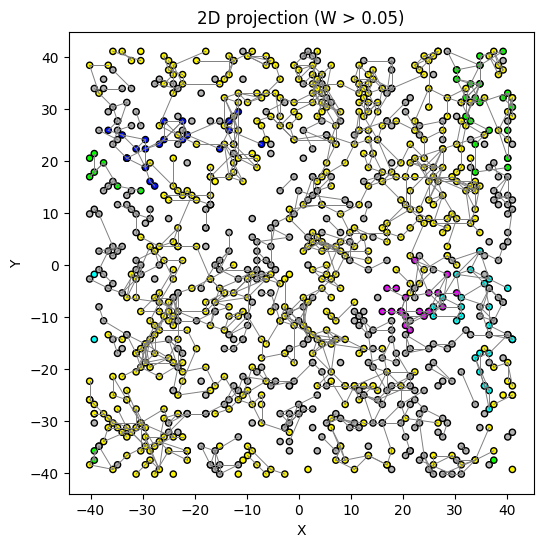

In [622]:
import seaborn as sns

box_size = 3.57 * (2 * size + 1)

components = list(nx.connected_components(G))
components_sorted = sorted(components, key=len, reverse=True)

num_top = 5
palette = sns.color_palette("hsv", num_top)  

node_colors = np.zeros((len(positions), 4))
gray = (0.7, 0.7, 0.7, 1.0)  # RGBA for small components

for idx, comp in enumerate(components_sorted):
    color = palette[idx] + (1.0,) if idx < num_top else gray
    for node in comp:
        node_colors[node] = color

fig, ax = plt.subplots(figsize=(6, 6))

for i, j in G.edges():
    pos_i = positions[i]
    pos_j = positions[j]

    delta = pos_i - pos_j
    delta_wrapped = delta - box_size * np.round(delta / box_size)

    dist_actual = np.linalg.norm(delta)
    dist_wrapped = np.linalg.norm(delta_wrapped)

    # Only draw if edge did not require wrapping
    if np.isclose(dist_actual, dist_wrapped, atol=1e-6):
        ax.plot([pos_i[0], pos_j[0]], [pos_i[1], pos_j[1]], color='gray', linewidth=0.7)

xs, ys = positions[:, 0], positions[:, 1]
ax.scatter(xs, ys, c=node_colors, s=20, edgecolors='k')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title(f"2D projection (W > {W_thresh})")
plt.axis('equal')
plt.show()

In [648]:
# Calculate percolation statistics
from tqdm import tqdm
import networkx as nx
from collections import Counter
import time
start_time = time.time()

thresholds = np.linspace(9e-3, 2e-1, 1000)
n_thresh = len(thresholds)

n_realizations = 100

mean_finite_cluster_size = np.zeros((n_realizations, n_thresh))
giant_component_frac = np.zeros((n_realizations, n_thresh))
cluster_size_hist = [[{} for _ in range(n_thresh)] for _ in range(n_realizations)]

for i in tqdm(range(n_realizations)):
    size = 14
    carbon_pts, _ = sample_special_positions(3.57, size, 1.1e-2, 0)
    wrapped_carbon_pts = wrap_positions(carbon_pts, size)
    W = calculate_W(size, wrapped_carbon_pts, 2.5e-5)
    
    for j, thresh in enumerate(thresholds):
        A = (W > thresh).astype(int)
        G = nx.from_numpy_array(A)
        components = list(nx.connected_components(G))
        sizes = np.array([len(c) for c in components])

        if len(sizes) == 0:
            mean_finite_cluster_size[i,j] = 0
            giant_component_frac[i,j] = 0
            cluster_size_hist[i][j] = {}
        else:
            giant = sizes.max()
            finite = sizes[sizes < giant]
            mean_finite_cluster_size[i,j] = np.mean(finite) if len(finite) > 0 else 0
            giant_component_frac[i,j] = giant / len(W)
            hist = Counter(finite)
            cluster_size_hist[i][j] = hist

end_time = time.time()
print(end_time-start_time)
            
mean_s = np.mean(mean_finite_cluster_size, axis=0)
std_s = np.std(mean_finite_cluster_size, axis=0)

mean_P_inf = np.mean(giant_component_frac, axis=0)
std_P_inf = np.std(giant_component_frac, axis=0)

Wc_index = np.argmax(mean_s)
Wc_star = thresholds[Wc_index]
print(f"Estimated W_c^* ≈ {Wc_star:.4e}")

from collections import Counter
combined_hist = Counter()
for i in range(n_realizations):
    combined_hist.update(cluster_size_hist[i][Wc_index])

s_vals = np.array(sorted(combined_hist.keys()))
n_s = np.array([combined_hist[s] for s in s_vals])
n_s = n_s / np.sum(n_s)


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:32:16<00:00, 55.36s/it]

5536.0625631809235
Estimated W_c^* ≈ 4.9533e-02


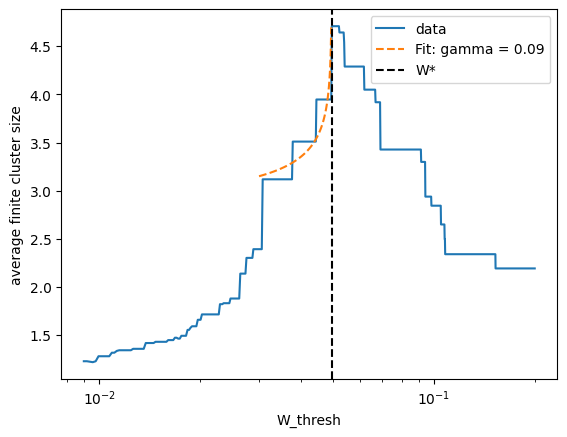

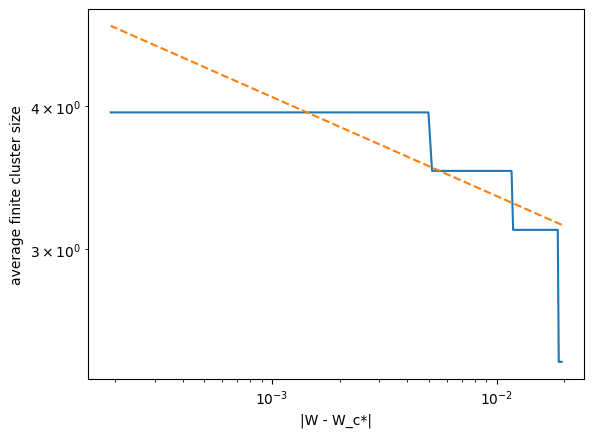

In [649]:
from scipy.optimize import curve_fit

mask_below = (thresholds < Wc_star) & (thresholds > 3e-2)

W_below = thresholds[mask_below]
s_below = mean_s[mask_below]

def gamma_fit(W, gamma, A):
    return A * (np.abs(W - Wc_star))**(-gamma)

popt, _ = curve_fit(gamma_fit, W_below, s_below, p0=(2, 1.0))
gamma, A = popt

plt.figure()
plt.semilogx(thresholds, mean_s, label='data')
plt.semilogx(W_below, gamma_fit(W_below, *popt), '--', label=f"Fit: gamma = {gamma:.2f}")
plt.axvline(Wc_star, color='k', linestyle='--', label="W*")
plt.xlabel("W_thresh")
plt.ylabel("average finite cluster size")
plt.legend()
plt.show()

plt.figure()
plt.loglog(np.abs(W_below - Wc_star), s_below, label='data')
plt.loglog(np.abs(W_below - Wc_star), gamma_fit(W_below, *popt), '--', label=f"Fit: gamma = {gamma:.2f}")
plt.xlabel("|W - W_c*|")
plt.ylabel("average finite cluster size")
plt.show()

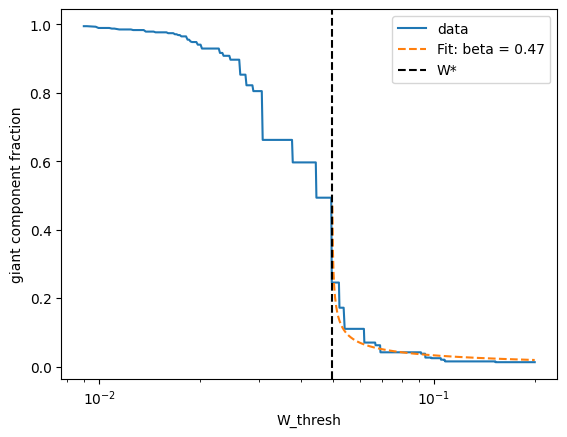

In [650]:
mask_above = (thresholds > Wc_star) & (thresholds < 1)

W_above = thresholds[mask_above]
P_above = mean_P_inf[mask_above]

def beta_fit(W, beta, A):
    return A * (W - Wc_star)**(-beta)

popt, _ = curve_fit(beta_fit, W_above, P_above, p0=(0.4, 1.0))
beta, A = popt

plt.figure()
plt.semilogx(thresholds, mean_P_inf, label="data")
plt.semilogx(W_above, beta_fit(W_above, *popt), '--', label=f"Fit: beta = {beta:.2f}")
plt.axvline(Wc_star, color='k', linestyle='--', label="W*")
plt.xlabel("W_thresh")
plt.ylabel("giant component fraction")
plt.legend()
plt.show()

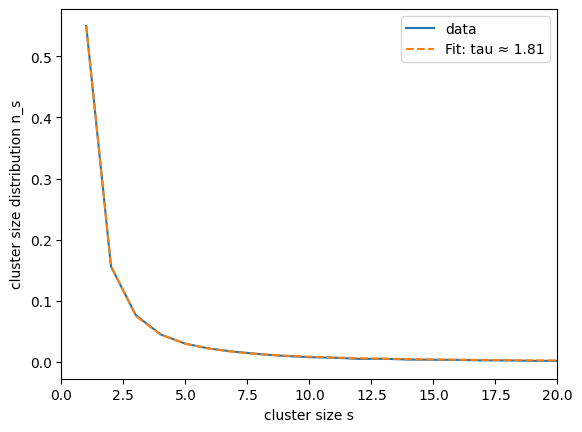

In [651]:
s_min = 1
s_max = 20
mask = (s_vals >= s_min) & (s_vals <= s_max)
s_fit = s_vals[mask]
n_s_fit = n_s[mask]

def tau_fit(s, tau, A):
    return A * s**(-tau)

popt, _ = curve_fit(tau_fit, s_fit, n_s_fit, p0=(2.0, 1.0))
tau, A = popt

plt.figure()
plt.plot(s_vals, n_s, label='data')
plt.plot(s_fit, tau_fit(s_fit, *popt), '--', label=f'Fit: tau ≈ {tau:.2f}')
plt.xlabel("cluster size s")
plt.ylabel("cluster size distribution n_s")
plt.xlim(0, 20)
plt.legend()
plt.show()

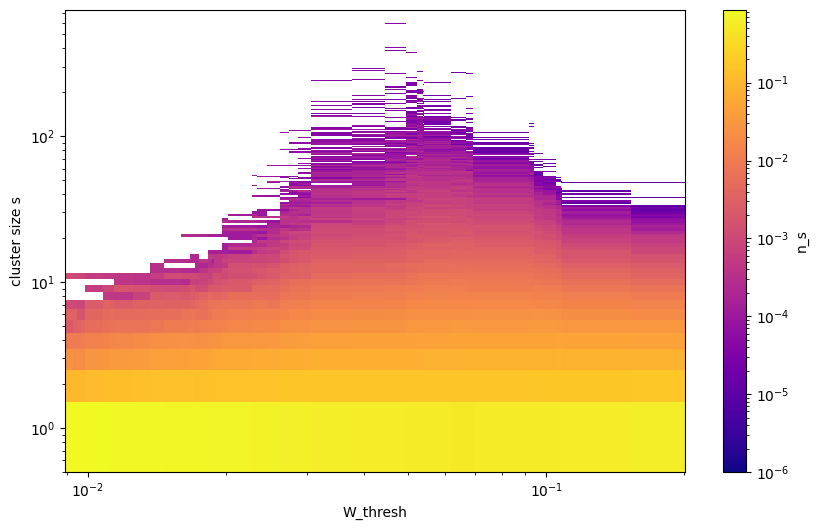

In [652]:
import matplotlib.colors as colors

# 1. Safely get max_s
max_s = max(
    max(hist.keys()) for hists in cluster_size_hist for hist in hists if hist
)

# 2. Initialize histogram matrix
histogram_matrix = np.zeros((max_s + 1, n_thresh))

# 3. Fill in the histogram matrix
for j in range(n_thresh):
    combined = Counter()
    for i in range(n_realizations):
        combined.update(cluster_size_hist[i][j])
    for s, count in combined.items():
        histogram_matrix[s, j] = count

# 4. Normalize across s (per threshold)
with np.errstate(invalid='ignore'):
    histogram_matrix /= histogram_matrix.sum(axis=0, keepdims=True)

# 5. Determine vmax safely
valid_vals = histogram_matrix[np.isfinite(histogram_matrix) & (histogram_matrix > 0)]
vmax = valid_vals.max() if valid_vals.size > 0 else 1.0

# Create meshgrid for plotting
s_vals_2 = np.arange(1, max_s + 1)
W_vals = thresholds  # log-spaced

# Create 2D grids for W and s
W_grid, S_grid = np.meshgrid(W_vals, s_vals_2)

plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(
    W_grid, S_grid, histogram_matrix[1:],  # skip s=0
    norm=colors.LogNorm(vmin=1e-6, vmax=vmax),
    shading='auto',
    cmap='plasma'
)

plt.colorbar(pcm, label='n_s')
plt.yscale('log')
plt.xscale('log')  
plt.xlabel("W_thresh")
plt.ylabel("cluster size s")
plt.show()

In [642]:
import time
start_time = time.time()

size = 7
carbon_pts, _ = sample_special_positions(3.57, size, 1.1e-2, 0)
wrapped_carbon_pts = wrap_positions(carbon_pts, size)
W = calculate_W(size, wrapped_carbon_pts, 2.5e-5)
t_max = 20
n_trajectories = 1000

all_wait_times, all_jump_lengths, msd_vs_steps, t_bins, msd_vs_time, distinct_sites_vs_steps, all_times, all_sites \
= ensemble_average(size, W, wrapped_carbon_pts, t_max, n_trajectories)

W_thresh = 5e-2 
A = (W > W_thresh).astype(int)
G = nx.from_numpy_array(A)
components = list(nx.connected_components(G))

site_to_component = {}
for idx, comp in enumerate(components):
    for site in comp:
        site_to_component[site] = idx
        
from collections import Counter

for traj_idx, sites in enumerate(all_sites):
    components_visited = [site_to_component[site] for site in sites if site in site_to_component]
    unique_comps = set(components_visited)
    
end_time = time.time()
print(end_time-start_time)
    
#     print(f"Trajectory {traj_idx}: visited components {unique_comps}")

3.04931902885437


C:\Users\Suber\AppData\Local\Temp\ipykernel_27728\1065765651.py:131: RuntimeWarning: Mean of empty slice
  msd_vs_time = np.nanmean(all_interp_disp, axis=0)


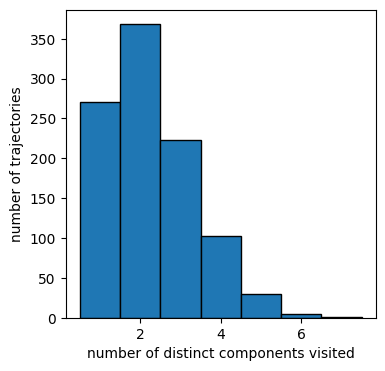

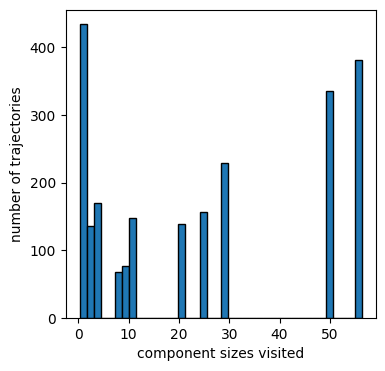

In [643]:
distinct_components_per_traj = []
component_sizes_per_traj = []

for sites in all_sites:
    comps_visited = [site_to_component.get(site, None) for site in sites]
    comps_visited = set(c for c in comps_visited if c is not None)
    
    distinct_components_per_traj.append(len(comps_visited))
    
    sizes = [len(components[c]) for c in comps_visited]
    component_sizes_per_traj.extend(sizes)

plt.figure(figsize=(4, 4))
plt.hist(distinct_components_per_traj, bins=range(1, max(distinct_components_per_traj)+2), align='left', edgecolor='black')
plt.xlabel("number of distinct components visited")
plt.ylabel("number of trajectories")
plt.show()

plt.figure(figsize=(4, 4))
plt.hist(component_sizes_per_traj, bins=40, align='left', edgecolor='black')
plt.xlabel("component sizes visited")
plt.ylabel("number of trajectories")
plt.show()

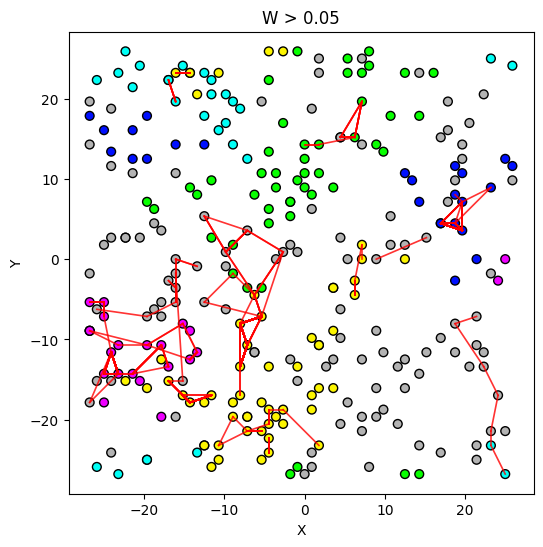

In [644]:
import seaborn as sns

positions = wrapped_carbon_pts
box_size = 3.57 * (2 * size + 1)

components = list(nx.connected_components(G))
components_sorted = sorted(components, key=len, reverse=True)

num_top = 5
palette = sns.color_palette("hsv", num_top) 

node_colors = np.zeros((len(positions), 4))
gray = (0.7, 0.7, 0.7, 1.0) 

for idx, comp in enumerate(components_sorted):
    color = palette[idx] + (1.0,) if idx < num_top else gray
    for node in comp:
        node_colors[node] = color


fig, ax = plt.subplots(figsize=(6, 6))
xs, ys = positions[:, 0], positions[:, 1]
ax.scatter(xs, ys, c=node_colors, s=40, edgecolors='k')

num_to_plot = 10
for traj in all_sites[:num_to_plot]:
    for i in range(len(traj) - 1):
        idx1 = traj[i]
        idx2 = traj[i + 1]

        pos1 = positions[idx1]
        pos2 = positions[idx2]

        delta = pos2 - pos1
        delta_wrapped = delta - box_size * np.round(delta / box_size)

        dist_actual = np.linalg.norm(delta)
        dist_wrapped = np.linalg.norm(delta_wrapped)

        # Only plot if the step didn't cross periodic boundary
        if np.isclose(dist_actual, dist_wrapped, atol=1e-6):
            ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], color='red', linewidth=1.2, alpha=0.8)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title(f"W > {W_thresh}")
plt.axis('equal')
plt.show()

In [147]:
# Calculate percolation statistics for several system sizes
from tqdm import tqdm
import networkx as nx
from collections import Counter
import time
start_time = time.time()

thresholds = np.linspace(2e-2, 2e-1, 1000)
n_thresh = len(thresholds)
n_realizations = 10
sizes = [7, 9, 11, 13, 15, 17]

results = {}

for size in sizes:
    
    print(f'running size {size}')
    
    mean_finite_cluster_size = np.zeros((n_realizations, n_thresh))
    giant_component_frac = np.zeros((n_realizations, n_thresh))
    cluster_size_hist = [[{} for _ in range(n_thresh)] for _ in range(n_realizations)]

    for i in tqdm(range(n_realizations)):
        carbon_pts, _ = sample_special_positions(3.57, size, 1.1e-2, 0)
        wrapped_carbon_pts = wrap_positions(carbon_pts, size)
        W = calculate_W(size, wrapped_carbon_pts, 2.5e-5)

        for j, thresh in enumerate(thresholds):
            A = (W > thresh).astype(int)
            G = nx.from_numpy_array(A)
            components = list(nx.connected_components(G))
            component_sizes = np.array([len(c) for c in components])

            if len(component_sizes) == 0:
                mean_finite_cluster_size[i,j] = 0
                giant_component_frac[i,j] = 0
                cluster_size_hist[i][j] = {}
            else:
                giant = component_sizes.max()
                finite = component_sizes[component_sizes < giant]
                mean_finite_cluster_size[i,j] = np.mean(finite) if len(finite) > 0 else 0
                giant_component_frac[i,j] = giant / len(W)
                hist = Counter(finite)
                cluster_size_hist[i][j] = hist
    
    mean_s = np.mean(mean_finite_cluster_size, axis=0)
    std_s = np.std(mean_finite_cluster_size, axis=0)
    
    mean_P_inf = np.mean(giant_component_frac, axis=0)
    std_P_inf = np.std(giant_component_frac, axis=0)

    Wc_index = np.argmax(mean_s)
    Wc_star = thresholds[Wc_index]
    
    results[size] = {
        'mean_s': mean_s,
        'std_s': std_s,
        'mean_P_inf': mean_P_inf,
        'std_P_inf': std_P_inf,
        'Wc_star': Wc_star,
        'cluster_hist': cluster_size_hist
    }

end_time = time.time()
print(end_time-start_time)
            



# print(f"Estimated W_c^* ≈ {Wc_star:.4e}")

# from collections import Counter
# combined_hist = Counter()
# for i in range(n_realizations):
#     combined_hist.update(cluster_size_hist[i][Wc_index])

# s_vals = np.array(sorted(combined_hist.keys()))
# n_s = np.array([combined_hist[s] for s in s_vals])
# n_s = n_s / np.sum(n_s)


running size 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.54s/it]


running size 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.68s/it]


running size 11


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:07<00:00, 12.72s/it]


running size 13


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:05<00:00, 30.58s/it]


running size 15


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:53<00:00, 65.32s/it]


running size 17


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [21:21<00:00, 128.14s/it]

2429.8325848579407


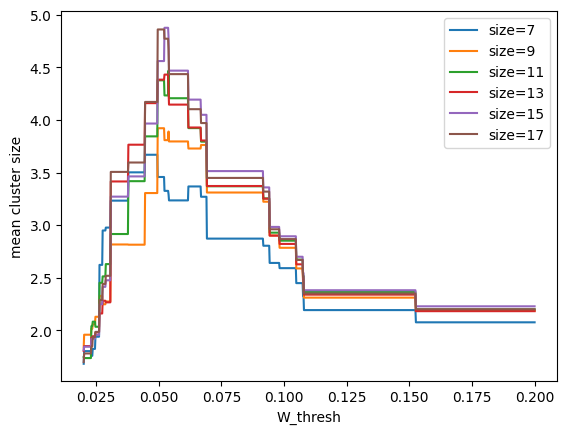

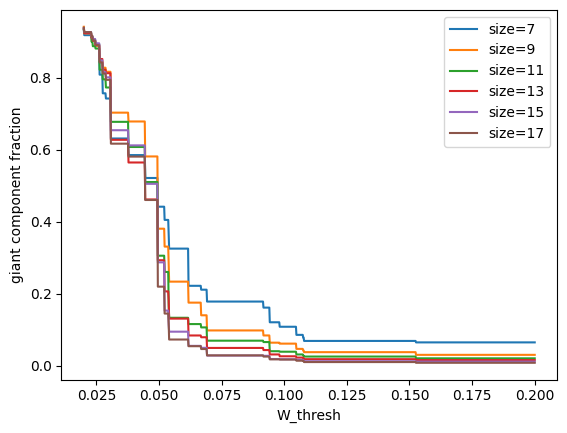

In [148]:
plt.figure()
for size in sizes:
    plt.plot(thresholds, results[size]['mean_s'], label=f"size={size}")
# plt.axvline(results[sizes[0]]['Wc_star'], color='k', linestyle='--')
plt.xlabel("W_thresh")
plt.ylabel("mean cluster size")
plt.legend()
plt.show()

plt.figure()
for size in sizes:
    plt.plot(thresholds, results[size]['mean_P_inf'], label=f"size={size}")
# plt.axvline(results[sizes[0]]['Wc_star'], color='k', linestyle='--')
plt.xlabel("W_thresh")
plt.ylabel("giant component fraction")
plt.legend()
plt.show()

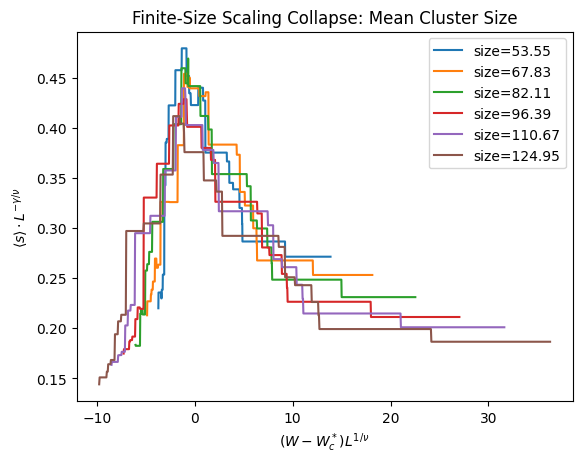

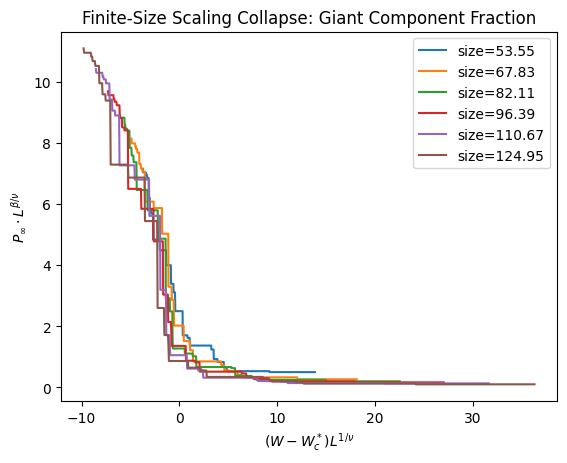

In [656]:
nu = 0.88
gamma = 0.45
beta = 0.45

Wc_star = results[sizes[-1]]['Wc_star']

plt.figure()
for size in sizes:
    L = 3.57 * (2*size + 1)
    mean_s = results[size]['mean_s']
    
    x = (thresholds - Wc_star) * (L ** (1 / nu))
    y = mean_s * (L ** (-gamma / nu))
    
    plt.plot(x, y, label=f"size={L:.2f}")

plt.xlabel(r"$(W - W_c^*) L^{1/\nu}$")
plt.ylabel(r"$\langle s \rangle \cdot L^{-\gamma/\nu}$")
plt.title("Finite-Size Scaling Collapse: Mean Cluster Size")
plt.legend()
plt.show()


plt.figure()
for size in sizes:
    L = 3.57 * (2*size + 1)
    P_inf = results[size]['mean_P_inf']
    
    x = (thresholds - Wc_star) * (L ** (1 / nu))
    y = P_inf * (L ** (beta / nu))
    
    plt.plot(x, y, label=f"size={L:.2f}")

plt.xlabel(r"$(W - W_c^*) L^{1/\nu}$")
plt.ylabel(r"$P_\infty \cdot L^{\beta/\nu}$")
plt.title("Finite-Size Scaling Collapse: Giant Component Fraction")
plt.legend()
plt.show()


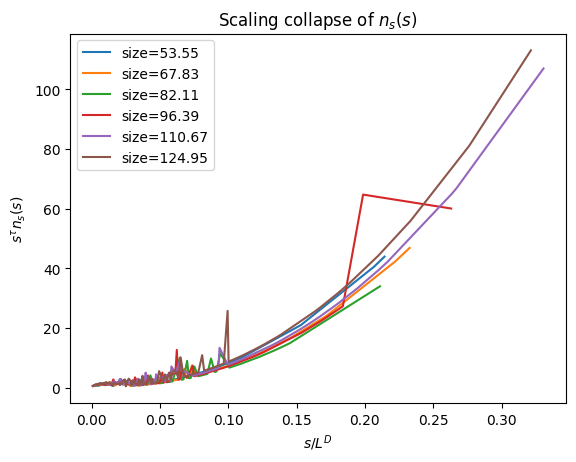

In [219]:
tau = 2.2
D_guess = 1.5

plt.figure()
for size in sizes:
    cluster_hist = results[size]['cluster_hist']
    Wc_index = np.argmax(results[size]['mean_s'])

    combined_hist = Counter()
    for i in range(n_realizations):
        combined_hist.update(cluster_hist[i][Wc_index])

    s_vals = np.array(sorted(combined_hist.keys()))
    n_s = np.array([combined_hist[s] for s in s_vals])
    n_s = n_s / np.sum(n_s) 

    L = 3.57 * (2*size + 1)
    x = s_vals / L**D_guess
    y = s_vals**tau * n_s

    plt.plot(x, y, label=f"size={L:.2f}")

plt.xlabel(r"$s / L^D$")
plt.ylabel(r"$s^\tau n_s(s)$")
plt.title("Scaling collapse of $n_s(s)$")
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.show()